In [1]:
import sys
sys.path.append("..")

import nidn
import torch

11:33:34|NIDN-INFO| Initialized NIDN for cpu
11:33:34|NIDN-INFO| Using double precision


## Uniform Titanium-Dixide Ground Truth

The following settings is used in order to compare the resulting spectrum to an experimentally measured for Titanium Dioxide, as found in this paper:  The wavelengths presendet by the paper is between 300 nm and 900 nm, and the thickness is 380 nm. Thus the same settings are used here

In [2]:
cfg = nidn.load_default_cfg()
# Set the number of frequencies to simulate for
cfg.N_freq = 50
#Number of layers with materials
cfg.N_layers = 1
# Define the thickness of the layer to be 380 nm
cfg.PER_LAYER_THICKNESS=[0.38]
#Set wavelength range to be 300 nm to 900 nm
cfg.physical_wavelength_range[0]=3e-7
cfg.physical_wavelength_range[1]=9e-7
# Choose FDTD method, TRCWA other option
cfg.solver = "FDTD"
# Set number of time steps in FDTD
cfg.FDTD_niter = 400
# Choose pulse type (continuous, hanning or ricker)
cfg.FDTD_pulse_type = 'continuous'
# Choose source type (line or point)
cfg.FDTD_source_type = 'line'
# Determine target frequencies (in TRCWA units)
cfg.target_frequencies = nidn.compute_target_frequencies(
    cfg.physical_wavelength_range[0],
    cfg.physical_wavelength_range[1],
    cfg.N_freq,
    cfg.freq_distribution
)

In [4]:
# Init eps_grid
eps_grid = torch.zeros(cfg.Nx,cfg.Ny,cfg.N_layers,cfg.N_freq,dtype=torch.cfloat)

layer_builder = nidn.LayerBuilder(cfg)
eps_grid[:,:,0,:] = layer_builder.build_uniform_layer("titanium_oxide")

C:\Users\to-bo\.conda\envs\nidn\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


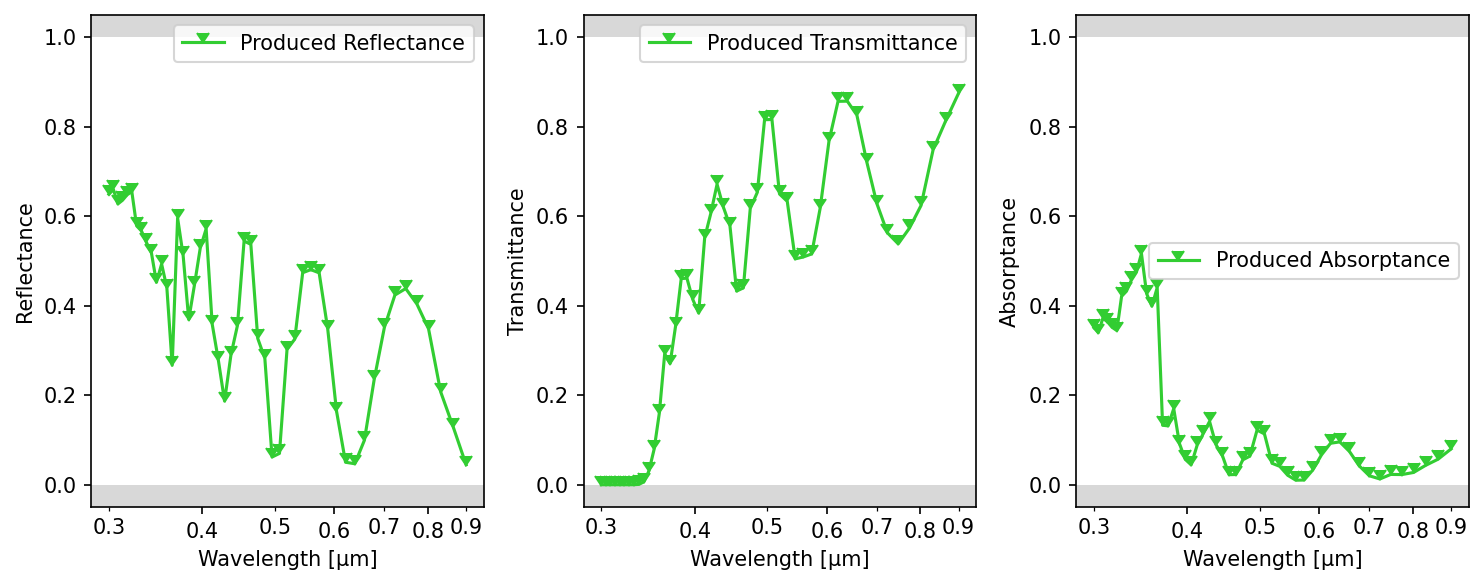

In [5]:
# Compute spectrum for this configuration
R,T = nidn.compute_spectrum(eps_grid,cfg)
nidn.plot_spectrum(cfg,R,T)

In [6]:
print("cfg.target_reflectance_spectrum = [", end="")
[print(f"{r.item():.8f}",end=",") for r in R]
print("]")
print("cfg.target_transmittance_spectrum = [",end="")
[print(f"{t.item():.8f}",end=",") for t in T]
print("]")

cfg.target_reflectance_spectrum = [0.04456351,0.12983103,0.20803709,0.34838794,0.40374041,0.43852469,0.42395525,0.35184451,0.23594347,0.09928435,0.04685543,0.05025798,0.16480385,0.34852490,0.47360640,0.48079059,0.47393927,0.32548627,0.30220670,0.06996665,0.06193323,0.28238744,0.32690241,0.53719555,0.54476352,0.35588386,0.29008964,0.18691291,0.27902207,0.35943538,0.57196896,0.52884206,0.44624134,0.36921438,0.51291333,0.59620698,0.26694859,0.44032823,0.49345384,0.45239907,0.51884675,0.54193479,0.56739480,0.57878280,0.65530901,0.64809091,0.63580893,0.62772046,0.66017392,0.64911847,]
cfg.target_transmittance_spectrum = [0.87536937,0.81306321,0.74871316,0.62422039,0.57356001,0.53846150,0.56318135,0.62822533,0.72190201,0.82619426,0.85741193,0.85703549,0.76844363,0.61871883,0.51589117,0.50911674,0.50488436,0.63344725,0.64983030,0.81641020,0.81593769,0.65369392,0.61752693,0.44001045,0.43281800,0.57915879,0.62005311,0.67163461,0.60661098,0.55207187,0.38364619,0.41434421,0.46167013,0.46081770,0.

## Uniform Three-Layer Ground Truth 

In [23]:
# Start with the default config
cfg = nidn.load_default_cfg()

# Set grid specifics
cfg.Nx = 1
cfg.Ny = 1
cfg.N_layers = 3
cfg.N_freq = 32
cfg.TRCWA_PER_LAYER_THICKNESS = [1.0]
cfg.freq_distribution = "linear"

# The wavelength range is set to cover visible light and also overlap with the smallest wavelength of TRCWA for comparison
cfg.physical_wavelength_range[0] = 3e-7 
cfg.physical_wavelength_range[1] = 3e-6

# Determine target frequencies (in TRCWA units)
cfg.target_frequencies = nidn.compute_target_frequencies(
    cfg.physical_wavelength_range[0],
    cfg.physical_wavelength_range[1],
    cfg.N_freq,
    cfg.freq_distribution
)
# Number of iterations is increased from previousl example due to a thicker layer which creates a longer path for the waves to travel trough. 
cfg.FDTD_niter = 800
cfg.solver ="FDTD"

In [24]:
# Init eps_grid
eps_grid = torch.zeros(cfg.Nx,cfg.Ny,cfg.N_layers,cfg.N_freq,dtype=torch.cfloat)
layer_builder = nidn.LayerBuilder(cfg)
eps_grid[:,:,0,:] = layer_builder.build_uniform_layer("titanium_oxide")
eps_grid[:,:,1,:] = layer_builder.build_uniform_layer("germanium")
eps_grid[:,:,2,:] = layer_builder.build_uniform_layer("tantalum_pentoxide")

In [25]:
# Compute spectrum for this configuration
R,T = nidn.compute_spectrum(eps_grid,cfg)
nidn.plot_spectrum(cfg,R,T)

ValueError: The transmission coefficient is outside of the physical range between 0 and 1

In [10]:
print("cfg.target_reflectance_spectrum = [", end="")
[print(f"{r.item():.8f}",end=",") for r in R]
print("]")
print("cfg.target_transmittance_spectrum = [",end="")
[print(f"{t.item():.8f}",end=",") for t in T]
print("]")

cfg.target_reflectance_spectrum = [0.14366185,0.18082630,0.44159215,0.13900707,0.42354783,0.24970388,0.30973613,0.47214355,0.30011608,0.15332924,0.09055452,0.60143572,0.51474908,0.37658953,0.27063780,0.45364774,0.55430213,0.21988917,0.32426597,0.39211774,0.63102091,0.10027350,0.06674312,0.65084378,0.16552294,0.11849790,0.70735398,0.70993483,0.61116687,0.66113145,0.70942884,0.58548506,]
cfg.target_transmittance_spectrum = [0.79465473,0.77935693,0.49396852,0.59691749,0.46510639,0.66354500,0.57803518,0.47349583,0.56241237,0.47413405,0.50198955,0.29456976,0.43202764,0.49411406,0.26503634,0.04106800,0.00099033,0.00000326,0.00000060,0.00000012,0.00000007,0.00000003,0.00000002,0.00000001,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,]


# Extract time signal for comparison

### Our implementation

In [11]:
from nidn.fdtd_integration.init_fdtd import init_fdtd
from nidn.fdtd_integration.compute_spectrum_fdtd import _get_detector_values
import matplotlib.pyplot as plt

In [12]:
cfg = nidn.load_default_cfg()
# Set the number of frequencies to simulate for
cfg.N_freq = 1
#Number of layers with materials
cfg.N_layers = 1
# Define the thickness of each layer
cfg.PER_LAYER_THICKNESS=[0.3]
#Smallest wavelength
cfg.physical_wavelength_range[0]=10e-7
#Largest wavelength
cfg.physical_wavelength_range[1]=10e-7
# Choose FDTD method, TRCWA other option
cfg.solver = "FDTD"
# Set number of time steps in FDTD
cfg.FDTD_niter = 400
# Choose pulse type (continuous, hanning or ricker)
cfg.FDTD_pulse_type = 'continuous'
# Choose source type (line or point)
cfg.FDTD_source_type = 'line'
# Determine target frequencies (in TRCWA units)
cfg.target_frequencies = nidn.compute_target_frequencies(
    cfg.physical_wavelength_range[0],
    cfg.physical_wavelength_range[1],
    cfg.N_freq,
    cfg.freq_distribution
)

In [14]:
# Init eps_grid
eps_grid = torch.zeros(cfg.Nx,cfg.Ny,cfg.N_layers,cfg.N_freq,dtype=torch.cfloat)
layer_builder = nidn.LayerBuilder(cfg)
eps_grid[:,:,0,:] = layer_builder.build_uniform_layer("titanium_oxide")

In [15]:
grid, t_detector_material, _  = init_fdtd(cfg,include_object = True, wavelength = cfg.physical_wavelength_range[0],permittivity = eps_grid[:,:,0,:])
plt.figure()
grid.visualize(z=0)
grid.run(cfg.FDTD_niter)

100%|██████████| 400/400 [00:02<00:00, 190.38it/s]


In [16]:
t_signal_material, r_ = _get_detector_values(t_detector_material,_)

### Original FDTD

In [18]:
import fdtd
from nidn.utils.global_constants import EPS_0, PI

fdtd.set_backend("torch")

SPEED_LIGHT: float = 299_792_458.0 
TIMESTEPS = 400

Set up the grid in the same way

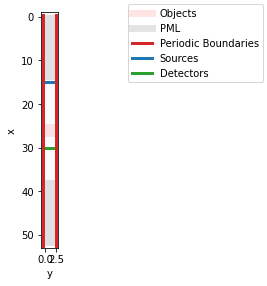

In [19]:
# create FDTD Grid
grid_spacing = 0.1 * cfg.physical_wavelength_range[0]
grid = fdtd.Grid(
    (5.3e-6,3, 1),  # 2D grid
    grid_spacing=grid_spacing,
    permittivity=1.0,  # Relative permittivity of 1  vacuum
)

# sources
grid[int(1.5e-6/grid_spacing), :] = fdtd.LineSource(period=cfg.physical_wavelength_range[0] / SPEED_LIGHT, name="source")

# detectors
t_detector_material = fdtd.LineDetector(name="detector")
grid[int(2.8e-6/grid_spacing)+2, :, 0] = t_detector_material

# x boundaries
grid[0:int(1.5e-6/grid_spacing), :, :] = fdtd.PML(name="pml_xlow")
grid[-int(1.5e-6/grid_spacing):, :, :] = fdtd.PML(name="pml_xhigh")

# y boundaries
grid[:, 0, :] = fdtd.PeriodicBoundary(name="ybounds")

# The absorbing object fills the whole grid
grid[int(2.5e-6/grid_spacing):int(2.8e-6/grid_spacing),:, :] = fdtd.AbsorbingObject(
    permittivity=eps_grid[:,:,0,0].real, conductivity=eps_grid[:,:,0,0].imag*SPEED_LIGHT/cfg.physical_wavelength_range[0]*2*PI*EPS_0, name="absorbin_object"
)
plt.figure()
grid.visualize(z=0)

Run the simulation

In [20]:
grid.run(TIMESTEPS, progress_bar= False)

Extract time domain signal from detector

In [21]:
raw_signal = []
t = []
for i in range(TIMESTEPS):
    #Add only the z component of the E field from the center point of the detector, as there is only z polarized waves
    raw_signal.append(t_detector_material.detector_values()['E'][i][1][2])
    t.append(i)
#raw_signal, r_ = _get_detector_values(t_detector_material,t_detector_material)

Plot the signal through the material for both cases, to see that thay match

Text(0.5, 0, 'Timestep')

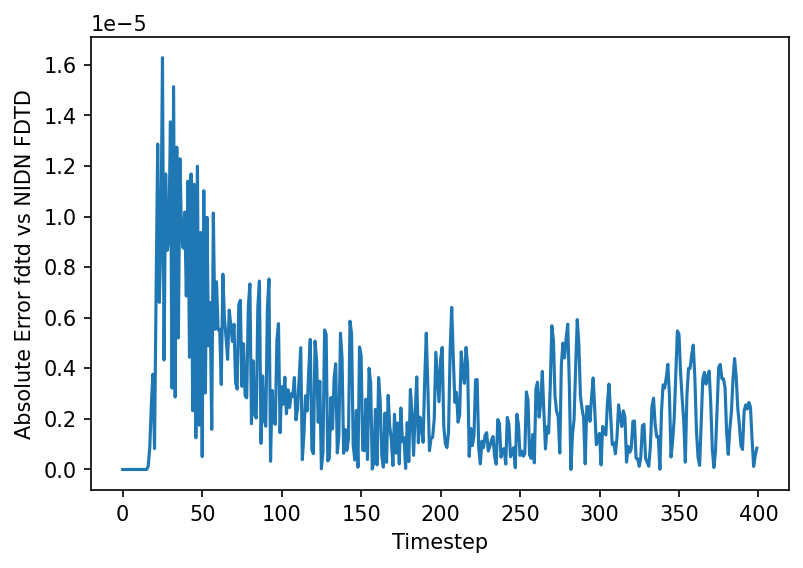

In [22]:
plt.figure(dpi=150)
plt.plot(t,torch.abs(torch.tensor(raw_signal)-t_signal_material)/torch.max(torch.tensor(raw_signal)))
plt.ylabel("Relative Error fdtd vs NIDN FDTD")
plt.xlabel("Timestep")